In [35]:
import os
os.chdir('../../')

In [36]:
os.environ['CUDA_VISIBLE_DEVICES']=str(3)

In [37]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as datasets
from models import cmlp
from utilities import fits
from flax import linen as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from utilities.plot import plot_binary_class,plot_caliberation_classification
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from functools import partial
from jax.flatten_util import ravel_pytree
try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq blackjax
    import blackjax
import probml_utils as pml
from probml_utils.blackjax_utils import inference_loop
from sklearn.calibration import calibration_curve,CalibrationDisplay
import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
from jax.random import PRNGKey as rng_key

In [38]:
os.environ['LATEXIFY'] = ''
os.environ['FIG_DIR'] = '.'

In [39]:
pml.latexify(width_scale_factor=2.4,fig_height=2)

# Dataset Visualization

In [40]:
X,Y =  datasets.make_moons(1000, noise=0.20,random_state=6)

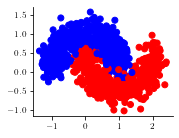

In [41]:
plt.scatter(X[:,0],X[:,1],c=Y,cmap="bwr")
sns.despine()

In [42]:
X_ood = tfd.MultivariateNormalDiag([2,-2],[0.2,0.2]).sample(seed =rng_key(0),sample_shape=50 )

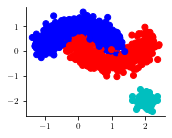

In [43]:
plt.scatter(X[:,0],X[:,1],c=Y,cmap="bwr")
plt.scatter(*X_ood.T,c='c')
sns.despine()

In [44]:
h=0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h),
                     jnp.arange(y_min, y_max, h))

In [45]:
xx.shape

(112, 136)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=45)

In [47]:
X_train = jnp.array(X_train)
X_test = jnp.array(X_test)
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)


# Single MLP

In [48]:
model = cmlp.cmlp([8,16,16,8,1],[nn.relu,nn.relu,nn.relu,nn.relu],[0.03]*4)

In [49]:
auxs = {
    "X" : X_train,
    "y" : y_train,
    "deterministic": True,
}

## Train

In [50]:
seed=0
params = model.init(jax.random.PRNGKey(seed), X_train, deterministic = True)
params, loss =  fits.fit(model, params,X_train,y_train,True,learning_rate=0.01, epochs=1000,batch_size=64)

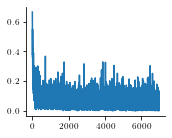

In [51]:
plt.plot(jnp.arange(0,loss.shape[0],1),loss)
sns.despine()

In [52]:
def plot_caliberation_classification(pred_train,pred_test,title,y_train,y_test,legend=0):
    fig,ax1 = plt.subplots(1,1)
    prob_true_train,prob_pred_train = calibration_curve(y_train,pred_train,n_bins=5)
    prob_true_test,prob_pred_test = calibration_curve(y_test,pred_test)

    disp_train = CalibrationDisplay(prob_true_train,prob_pred_train,pred_train,estimator_name="Train")
    disp_test = CalibrationDisplay(prob_true_test,prob_pred_test,pred_test,estimator_name="Test",)
    disp_train.plot(ax=ax1)
    disp_test.plot(ax=ax1)
    handles,labels = ax1.get_legend_handles_labels()
    labels[0] = 'Ideal'
    sns.despine(ax=ax1)

    ax1.legend(handles,labels,loc=legend)
    ax1.set_title(title)

In [53]:
y_pred_train = model.apply(params, X_train, deterministic=True)
y_pred_test = model.apply(params, X_test, deterministic=True)

In [54]:
plot_caliberation_classification = partial(plot_caliberation_classification,y_train=y_train,y_test=y_test)

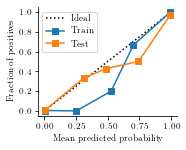

In [55]:
mlp_pred_train = model.apply(params,X_train,deterministic=True).reshape(y_train.shape)
mlp_pred_test = model.apply(params,X_test,deterministic=True).reshape(y_test.shape)
plot_caliberation_classification(mlp_pred_train,mlp_pred_test,title="")
# pml.savefig("figures/MLP_caliberation.pdf")

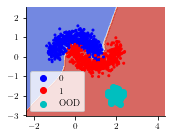

In [56]:
p =model.apply(params,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True).reshape(xx.shape)
var = p*(1-p).reshape(xx.shape)

plot_binary_class(X,Y,X_ood,xx,yy,p,titles=("Probability with Single MLP","Variance with Single MLP"),legend=True)
# pml.savefig("figures/mlp_moons.pdf",tight_bbox=False)
#pml.savefig("MLP_moons.pdf")

# Deep Ensemble

In [57]:
def de_train(x, y, i, model):
    param =  model.init(jax.random.PRNGKey(i), X, True)
    param, losses = fits.fit(model, param, x, y, True,learning_rate=0.01, epochs= 100)
    return param, losses

de_train = jax.tree_util.Partial(de_train, model=model)
params_list, losses_list = jax.jit(jax.vmap(de_train, in_axes=(None, None, 0)))(X_train, y_train, jnp.arange(5))

In [58]:
def predict(x, param, model):
    yhat = model.apply(param,x,True)
    return yhat

In [59]:
train_ = jax.tree_util.Partial(predict, model=model)
y_stacks_train = jax.jit(jax.vmap(train_, in_axes=(None,0)))(X_train, params_list)

test_ = jax.tree_util.Partial(predict, model=model)
y_stacks_test = jax.jit(jax.vmap(test_, in_axes=(None,0)))(X_test, params_list)

complete_ = jax.tree_util.Partial(predict, model=model)
y_stacks_complete = jax.jit(jax.vmap(complete_, in_axes=(None,0)))(jnp.c_[xx.ravel(), yy.ravel()], params_list)

In [60]:
ensemble_pred_train = jnp.array(y_stacks_train).mean(axis=0).reshape(y_train.shape)
ensemble_pred_test= jnp.array(y_stacks_test).mean(axis=0).reshape(y_test.shape)
ensemble_p_mean = jnp.array(y_stacks_complete).mean(axis=0).reshape(xx.shape)
ensemble_p_sigma = jnp.sqrt(ensemble_p_mean*(1-ensemble_p_mean))

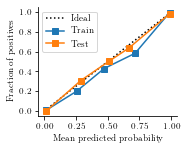

In [61]:
plot_caliberation_classification(ensemble_pred_train,ensemble_pred_test,title="",legend=0)
# pml.savefig("figures/Deep Ensemble caliberation.pdf")

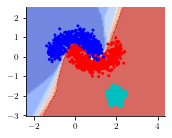

In [62]:
plot_binary_class(X,Y,X_ood,xx,yy,ensemble_p_mean,titles=("Probability with Deep ensemble","Variance with Deep Ensemble"),legend=False)
# pml.savefig("figures/Deep Ensemble Moons.pdf")

### MC Dropout

In [67]:
y_stacks = []
n_stacks = 50
@jax.jit
def func(params, i):
    z = model.apply(params, jnp.c_[xx.ravel(), yy.ravel()], deterministic=False, 
                    rngs={"dropout": jax.random.PRNGKey(i)}).reshape(xx.shape)
    return z
y_stacks = jax.vmap(fun=func, in_axes=(None, 0))(params, jnp.arange(n_stacks))

In [68]:
mc_pred_mean= jnp.array(y_stacks).mean(axis=0).reshape(xx.shape)
mc_pred_sigma = (jnp.array(y_stacks).std(axis=0)).reshape(yy.shape)

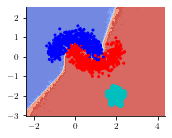

In [69]:
plot_binary_class(X,Y,X_ood,xx,yy,mc_pred_mean,titles=("Probability with MC Droput","Variance with MC Dropout"))
# pml.savefig("figures/MC Dropout Moons.pdf")

In [70]:
def create_apply_func(X_test):
    def func(params, i):
        z = model.apply(params, X_test, deterministic=False, 
                        rngs={"dropout": jax.random.PRNGKey(i)})
        return z
    return func
y_stacks_train = jax.vmap(fun=create_apply_func(X_train), in_axes=(None, 0))(params, jnp.arange(n_stacks))
y_stacks_test = jax.vmap(fun=create_apply_func(X_test), in_axes=(None, 0))(params, jnp.arange(n_stacks))


In [71]:
mc_pred_train = y_stacks_train.mean(axis=0)
mc_pred_test = y_stacks_test.mean(axis=0)

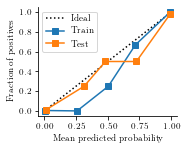

In [72]:
plot_caliberation_classification(mc_pred_train,mc_pred_test,title='')
# pml.savefig("figures/MC_dropout_caliberation.pdf")

### Bootstrap

In [73]:
def bs_train(x, y, i, model):
    idx = jax.random.choice(jax.random.PRNGKey(i), jnp.arange(len(x)), (len(x),))
    new_x, new_y = x[idx], y[idx]
    param =  model.init(jax.random.PRNGKey(i), x, True)
    param, losses = fits.fit(model, param, new_x, new_y, True, batch_size=len(x), learning_rate=0.01, epochs= 100)
    return param, losses
bs_train = jax.tree_util.Partial(bs_train, model=model)
params_list, losses_list = jax.jit(jax.vmap(bs_train, in_axes=(None, None, 0)))(X_train, y_train, jnp.arange(10))

In [74]:
train_ = jax.tree_util.Partial(predict, model=model)
y_stacks_train = jax.jit(jax.vmap(train_, in_axes=(None,0)))(X_train, params_list)

test_ = jax.tree_util.Partial(predict, model=model)
y_stacks_test = jax.jit(jax.vmap(test_, in_axes=(None,0)))(X_test, params_list)

complete_ = jax.tree_util.Partial(predict, model=model)
y_stacks_complete = jax.jit(jax.vmap(complete_, in_axes=(None,0)))(jnp.c_[xx.ravel(), yy.ravel()], params_list)

In [75]:
bootstrap_pred_train = jnp.array(y_stacks_train).mean(axis=0).reshape(y_train.shape)
bootstrap_pred_test= jnp.array(y_stacks_test).mean(axis=0).reshape(y_test.shape)
bootstrap_p_mean = jnp.array(y_stacks_complete).mean(axis=0).reshape(xx.shape)
bootstrap_p_sigma = jnp.sqrt(bootstrap_p_mean*(1-bootstrap_p_mean))

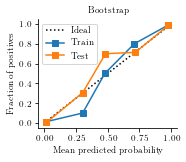

In [77]:
plot_caliberation_classification(bootstrap_pred_train,bootstrap_pred_test,title="Bootstrap")
# pml.savefig("figures/Bootstrap caliberation.pdf")

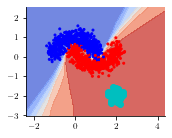

In [78]:
plot_binary_class(X,Y,X_ood,xx,yy,bootstrap_p_mean,titles=("Probability with Bootstrap","Variance with Bootstrap"))
# pml.savefig("figures/Bootstrap Moons.pdf")

In [79]:
params = model.init(jax.random.PRNGKey(seed), X_train, deterministic = True)


# NUTS

In [80]:
from jax import tree_map,tree_leaves
def glorot_prior(param):
    if(param.ndim==1):
        return tfd.Normal(loc = jnp.zeros_like(param), scale = (1.414/jnp.sqrt(param.shape[0])) )
    else:
        return tfd.Normal(loc=jnp.zeros_like(param),scale=(1.414/jnp.sqrt(param.shape[0]+param.shape[1])))

def one_prior(param):
    if(param.ndim==1):
        return tfd.Normal(loc = jnp.zeros_like(param), scale =0.5)
    else:
        return tfd.Normal(loc=jnp.zeros_like(param),scale=0.5)


def set_prior(mean,scale,params):
    priors = tree_map(glorot_prior,params)
    return priors


def eval_log(prior,param):
    return prior.log_prob(param).sum()

def eval_log_prior(params,priors):
    is_leaf = lambda x: isinstance(x, tfd.Distribution)
    # params_unfreezed = unfreeze(params)
    log_priors = tree_map(eval_log,priors,params,is_leaf=is_leaf)
    return jnp.array(tree_leaves(log_priors)).sum()

def eval_likelihood(params,model,X,Y):
    return tfd.Bernoulli(logits=model.apply(params,X,deterministic=True)).log_prob(Y.reshape((-1,1))).sum()

def log_joint(params,priors,model,X,Y):
    log_prior = eval_log_prior(params,priors=priors)
    log_likelihood = eval_likelihood(params,model,X,Y)
    return log_prior+log_likelihood
    # return log_likelihood

priors = set_prior(0,1,params)
bnn_log_joint_partial = partial(log_joint,model=model,priors=priors,X=X_train,Y=y_train)
bnn_log_joint_partial(params)

DeviceArray(-452.81613, dtype=float32)

In [81]:
def bnn_log_joint(params:dict, X, y, model):
    """
    computes the numerator term of the posterior funtion.

    params: dictionary initalized by model 
    X: shape-(n_samples,2) training points 
    y: shape-(n_samples,) labels for training points
    model: bnn model
    """
    
    logits = model.apply(params, X,deterministic=True).ravel()
    # flatten_params gives a list with all the parameters. its dimension will be 1.
    flatten_params, _ = ravel_pytree(params)
    log_prior = tfd.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    log_likelihood = tfd.Bernoulli(logits=logits).log_prob(y).sum()
    log_joint = log_prior + log_likelihood
    return log_joint +log_likelihood

params = model.init(jax.random.PRNGKey(0), X_train, deterministic = True)
bnn_log_joint_partial =partial(bnn_log_joint,X=X,y=Y,model=model)
bnn_log_joint_partial(params)

DeviceArray(-1999.239, dtype=float32)

In [82]:
from pandas import read_pickle
states,infos = read_pickle("mcmc_moons.pkl")['states'],read_pickle("mcmc_moons.pkl")['infos']

FileNotFoundError: [Errno 2] No such file or directory: 'mcmc_moons.pkl'

In [83]:
num_warmup = 3000
key = jax.random.PRNGKey(314)
key_samples, key_init, key_warmup, key = jax.random.split(key, 4)
adapt = blackjax.window_adaptation(blackjax.nuts, bnn_log_joint_partial, num_warmup,progress_bar=True)
final_state, kernel, _ = adapt.run(key_warmup, params)

Running window adaptation


In [ ]:
num_samples = 3000
states,infos = inference_loop(key_samples, kernel, final_state, num_samples)

In [ ]:
from pandas import to_pickle
to_pickle({"states":states,"infos":infos},"mcmc_moons_glorot_3000.pkl")

In [ ]:
seed = jax.random.PRNGKey(0)

def predict_mcmc(x_test):
    def one_step(carry, state):
        params_cur = state.position
        # samples = tfd.Bernoulli(probs=model.apply(params_cur,x_test,deterministic=True)).sample(seed=seed)
        probs=model.apply(params_cur,x_test,deterministic=True)
        return carry, probs
    _, y_stacks = jax.lax.scan(one_step, None, states)
    y_stacks = y_stacks>=0.5
    mean = y_stacks.mean(axis=0)
    std_dev = y_stacks.std(axis=0)
    return mean,std_dev

mcmc_pred_mean,mcmc_pred_sigma = predict_mcmc(jnp.c_[xx.ravel(), yy.ravel()])
mcmc_pred_mean,mcmc_pred_sigma = mcmc_pred_mean.reshape(xx.shape),mcmc_pred_sigma.reshape(xx.shape)

In [ ]:
mcmc_pred_mean[0][0]

In [ ]:
mcmc_pred_train, _= predict_mcmc(X_train)
mcmc_pred_test,_ = predict_mcmc(X_test)
plot_caliberation_classification(mcmc_pred_train,mcmc_pred_test,title="MCMC")
pml.savefig("figures/MCMC_caliberation_glorot_.pdf")

In [ ]:
def plot_binary_class(
    X_scatters,
    y_scatters,
    XX1_grid,
    XX2_grid,
    grid_preds_mean,
    grid_preds_sigma,
    titles: tuple,
):
    """
  funtion to binary classificaton outputs
@@ -160,22 +161,25 @@ def plot_binary_class(
  titles: tuple with title of the two images. 
  """

    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    ax[0].set_title(titles[0], fontsize=16)
    ax[0].contourf(XX1_grid, XX2_grid, grid_preds_mean, cmap="coolwarm", alpha=0.8)
    hs = ax[0].scatter(X_scatters.T[0], X_scatters.T[1], c=y_scatters, cmap="bwr")
    ax[0].legend(*hs.legend_elements(), fontsize=20)

    ax[1].set_title(titles[1], fontsize=16)
    CS = ax[1].contourf(XX1_grid, XX2_grid, grid_preds_sigma, cmap="viridis", alpha=0.8)
    hs = ax[1].scatter(X_scatters.T[0], X_scatters.T[1], c=y_scatters, cmap="bwr")
    # ax[1].legend(*hs.legend_elements(), fontsize=20)
    fig.colorbar(CS, ax=ax[1])
    sns.despine()

In [ ]:
titles_mcmc = ("Mean of Predictions of NUTS","Variance of Predictions of NUTS")
plot_binary_class(X_scatters=X,y_scatters=Y,XX1_grid=xx,
XX2_grid = yy,grid_preds_mean=mcmc_pred_mean,grid_preds_sigma=mcmc_pred_sigma,titles=titles_mcmc)
pml.savefig("figures/BNN using MCMC.pdf")
plt.show()

# GP

In [ ]:
import GPy
import numpy as np
# h=0.02
# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
# xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h),
#                      jnp.arange(y_min, y_max, h))

model = GPy.models.GPClassification(np.array(X_train), np.array(y_train.reshape(-1,1)))
print(model)
print(model.log_likelihood())
model.optimize(messages=True)
model.optimize_restarts(num_restarts=5)
print(model)
model.plot_f()
probability_gp,na = model.predict(jnp.c_[xx.ravel(), yy.ravel()])

In [ ]:
probability_gp = probability_gp.reshape(xx.shape)
# sigma_gp = jnp.sqrt(probability_gp*(1-probability_gp)).reshape(xx.shape)


In [ ]:
plot_binary_class(X,Y,X_ood,xx,yy,probability_gp,titles=("Probability with GP","Variance with GP"))
pml.savefig("figures/GP moons.pdf")

In [ ]:
gp_pred_train,na = model.predict(X_train)
gp_pred_test, na = model.predict(X_test)
plot_caliberation_classification(gp_pred_train,gp_pred_test,title="GP prediction")
pml.savefig("figures/GP_caliberation.pdf")

# SNGP

In [ ]:
%pip install -qq tf-models-official

In [ ]:
import pkg_resources
import importlib
importlib.reload(pkg_resources)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
try:
    import official.nlp.modeling.layers as nlp_layers
except ModuleNotFoundError:
    %pip install -qq tf-models-official
    import official.nlp.modeling.layers as nlp_layers

    

In [ ]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the resnet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid

    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

In [ ]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes, 
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and covariance matrix from GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

In [ ]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [ ]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)

In [ ]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

  return tf.nn.softmax(logits_adjusted, axis=-1)[:, 0]

In [ ]:
DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_N_GRID = 100


In [ ]:
def make_training_data(sample_size=500):
  """Create two moon training dataset."""
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

  # Adjust data position slightly.
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  """Create a mesh grid in 2D space."""
  # testing data (mesh grid over data space)
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)
  xv, yv = np.meshgrid(x, y)
  return np.stack([xv.flatten(), yv.flatten()], axis=-1),xv,yv

X_train,y_train = make_training_data(
    sample_size=500)

X_test,xx,yy = make_testing_data()

In [ ]:
def train_and_test_sngp(X_train, X_test):
  sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)

  sngp_model.compile(**train_config)
  sngp_model.fit(X_train, np.array(y_train), verbose=0, **fit_config)

  sngp_logits, sngp_covmat = sngp_model(X_test, return_covmat=True)
  sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

  return sngp_probs

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
resnet_config = dict(num_classes=2, num_layers=6, num_hidden=128)
train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)
fit_config = dict(batch_size=128, epochs=1000)

In [ ]:
X_train.shape

In [ ]:
import numpy as np
sngp_probs = train_and_test_sngp(np.array(X_train), X_test)

In [ ]:
sngp_std = np.sqrt(sngp_probs*(1-sngp_probs))

In [ ]:
sngp_probs = jnp.array(sngp_probs).reshape(xx.shape)

In [ ]:
sngp_std = jnp.array(sngp_std).reshape(xx.shape)

In [ ]:
plot_binary_class(X,Y,xx,yy,sngp_probs,sngp_std,titles=("Probability with SNGP","Variance with SNGP"))


In [ ]:
plot_binary_class(X,Y,xx,yy,sngp_probs,sngp_std,titles=("Probability with SNGP","Variance with SNGP"))


In [ ]:
sngp_pred_train = train_and_test_sngp(np.array(X_train), X_train)

In [ ]:
# sngp_pred_test = train_and_test_sngp(np.array(X_train), X_train)

In [ ]:
def plot_caliberation_classification(pred_train,pred_test,title):
    fig,ax1 = plt.subplots(1,1)
    prob_true_train,prob_pred_train = calibration_curve(y_train,pred_train,n_bins=5)
    # prob_true_test,prob_pred_test = calibration_curve(y_train,pred_test)

    disp_train = CalibrationDisplay(prob_true_train,prob_pred_train,pred_train,estimator_name="Train")
    # disp_test = CalibrationDisplay(prob_true_test,prob_pred_test,pred_test,estimator_name="Test",)

    disp_train.plot(ax=ax1)
    # disp_test.plot(ax=ax1)
    sns.despine(ax=ax1)
    ax1.legend(loc=0)
    ax1.set_title(title)

In [ ]:
plot_caliberation_classification(sngp_pred_train,sngp_pred_train,"SNGP")